In [2]:
from lib_log_parse import load_parsed_logs, parse
from datetime import datetime
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval

In [2]:
logs_with_hydras = [
    "./dht/2022-10-04-data-w-hydras/0.log",
    "./dht/2022-10-04-data-w-hydras/1.log",
    "./dht/2022-10-04-data-w-hydras/2.log",
    "./dht/2022-10-04-data-w-hydras/3.log",
    "./dht/2022-10-04-data-w-hydras/4.log",
    "./dht/2022-10-04-data-w-hydras/5.log",
]

logs_without_hydras = [
    "./dht/2022-10-04-data-wo-hydras/0.log",
    "./dht/2022-10-04-data-wo-hydras/1.log",
    "./dht/2022-10-04-data-wo-hydras/2.log",
    "./dht/2022-10-04-data-wo-hydras/3.log",
    "./dht/2022-10-04-data-wo-hydras/4.log",
    "./dht/2022-10-04-data-wo-hydras/5.log",
]

try:
    parsed_logs_with_hydras = load_parsed_logs(logs_with_hydras)
except Exception:
    parsed_logs_with_hydras = parse(logs_with_hydras)

try:
    parsed_logs_without_hydras = load_parsed_logs(logs_without_hydras)
except Exception:
    parsed_logs_without_hydras = parse(logs_without_hydras)

Loading  ./dht/2022-10-04-data-w-hydras/0.log
Took 0:00:02.098586
Loading  ./dht/2022-10-04-data-w-hydras/1.log
Took 0:00:03.633593
Loading  ./dht/2022-10-04-data-w-hydras/2.log
Took 0:00:03.588176
Loading  ./dht/2022-10-04-data-w-hydras/3.log
Took 0:00:03.246493
Loading  ./dht/2022-10-04-data-w-hydras/4.log
Took 0:00:06.556553
Loading  ./dht/2022-10-04-data-w-hydras/5.log
Took 0:00:04.645646
Loading  ./dht/2022-10-04-data-wo-hydras/0.log
Took 0:00:00.368129
Loading  ./dht/2022-10-04-data-wo-hydras/1.log
Took 0:00:00.392115
Loading  ./dht/2022-10-04-data-wo-hydras/2.log
Took 0:00:05.199939
Loading  ./dht/2022-10-04-data-wo-hydras/3.log
Took 0:00:00.409269
Loading  ./dht/2022-10-04-data-wo-hydras/4.log
Took 0:00:00.415833
Loading  ./dht/2022-10-04-data-wo-hydras/5.log
Took 0:00:00.402603


In [3]:
retrievals_by_hydras = {}
overall_retrieval_duration_per_region_by_hydras = {}
dht_ret_walks_duration_per_region_by_hydras = {}
dht_ret_find_first_provider_per_region_by_hydras = {}
content_fetch_duration_per_region_by_hydras = {}
retrieval_find_provider_queries_per_region_by_hydras = {}
retrieval_errors_per_region_by_hydras = {}

for hydras in ["with", "without"]:
    if hydras == "with":
        parsed_logs = parsed_logs_with_hydras
    elif hydras == "without":
        parsed_logs = parsed_logs_without_hydras
    else:
        raise Exception("NOOO")

    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in parsed_logs:
        publications += parsed_log.publications
        retrievals += parsed_log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    overall_retrieval_duration_per_region: Dict[str, List[float]] = {}
    dht_ret_walks_duration_per_region: Dict[str, List[float]] = {}
    dht_ret_find_first_provider_per_region: Dict[str, List[float]] = {}
    content_fetch_duration_per_region: Dict[str, List[float]] = {}
    retrieval_find_provider_queries_per_region: Dict[str, List[int]] = {}
    retrieval_errors_per_region: Dict[str, int] = {}

    for ret in retrievals:
        region: Optional[str] = None
        for no in log_no_to_region:
            if f"{no}.log" in ret.origin:
                region = log_no_to_region[no]
        if region is None:
            raise Exception("AHH")

        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        if ret.done_retrieving_error is not None:
            print(f"{ret.cid} in {ret.origin} had error: {ret.done_retrieving_error}")
            if region not in retrieval_errors_per_region:
                retrieval_errors_per_region[region] = 0
            retrieval_errors_per_region[region] += 1

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        if region not in overall_retrieval_duration_per_region:
            overall_retrieval_duration_per_region[region] = []
        overall_retrieval_duration_per_region[region] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walk_duration = 2 * ret.get_dht_walk_duration()
        if region not in dht_ret_walks_duration_per_region:
            dht_ret_walks_duration_per_region[region] = []
        dht_ret_walks_duration_per_region[region] += [dht_walk_duration]

        dht_ret_find_first_provider = (
                ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()
        if region not in dht_ret_find_first_provider_per_region:
            dht_ret_find_first_provider_per_region[region] = []
        dht_ret_find_first_provider_per_region[region] += [dht_ret_find_first_provider]

        content_fetch_duration = (ret.done_retrieving_at - ret.dial_started_at).total_seconds()
        if region not in content_fetch_duration_per_region:
            content_fetch_duration_per_region[region] = []
        content_fetch_duration_per_region[region] += [content_fetch_duration]

        if region not in retrieval_find_provider_queries_per_region:
            retrieval_find_provider_queries_per_region[region] = []

        retrieval_find_provider_queries_per_region[region] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))
        ]

    overall_retrieval_duration_per_region_by_hydras[hydras] = overall_retrieval_duration_per_region
    dht_ret_walks_duration_per_region_by_hydras[hydras] = dht_ret_walks_duration_per_region
    dht_ret_find_first_provider_per_region_by_hydras[hydras] = dht_ret_find_first_provider_per_region
    content_fetch_duration_per_region_by_hydras[hydras] = content_fetch_duration_per_region
    retrieval_find_provider_queries_per_region_by_hydras[hydras] = retrieval_find_provider_queries_per_region
    retrieval_errors_per_region_by_hydras[hydras] = retrieval_errors_per_region
    retrievals_by_hydras[hydras] = retrievals

skip None 2022-10-05 06:30:04.312433+00:00
skip None 2022-10-05 13:27:18.037712+00:00
skip None 2022-10-05 20:04:51.145686+00:00
skip None 2022-10-06 06:01:43.575055+00:00
skip None 2022-10-06 12:26:54.692380+00:00
skip None 2022-10-06 15:29:39.879830+00:00
skip None 2022-10-06 21:04:28.382226+00:00
skip None 2022-10-06 23:34:57.368030+00:00
skip None 2022-10-07 12:49:53.130092+00:00
skip None 2022-10-07 18:18:40.687673+00:00
skip None 2022-10-08 02:13:27.560965+00:00
skip None 2022-10-09 14:16:57.280280+00:00
skip None 2022-10-10 05:53:19.911328+00:00
skip None 2022-10-04 22:39:29.162193+00:00
skip None 2022-10-05 00:20:30.990759+00:00
skip None 2022-10-05 15:12:39.213497+00:00
QmVpgKQhEh1vuA2zyChbxHruv6aRmgVAN96PgvoMRZpwug in ./dht/2022-10-04-data-w-hydras/1.log had error: context canceled
skip None 2022-10-05 16:57:14.473200+00:00
skip None 2022-10-05 21:52:43.886596+00:00
skip None 2022-10-06 01:57:35.288901+00:00
skip None 2022-10-06 09:11:59.185403+00:00
skip None 2022-10-06 09:2

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

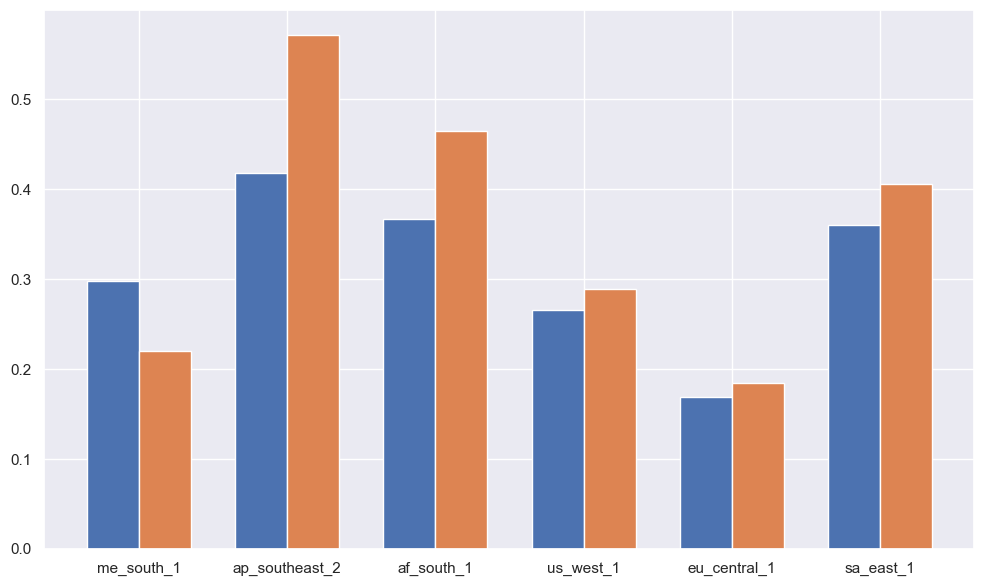

In [25]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.35
regions = log_no_to_region.values()
xs = np.arange(len(regions))

for hydra in ["with", "without"]:
    sign = 1 if hydra == "without" else -1
    percentiles = []
    for region in regions:
        percentiles += [
            np.percentile(np.array(dht_ret_find_first_provider_per_region_by_hydras[hydra][region]) / 2, 50)]
    ax.bar(xs + sign * width / 2, percentiles, width, label=hydra)

ax.set_xticks(xs, regions)

50 0.7185630000000001
90 1.5189485
95 2.447890299999995


(0.0, 3.0)

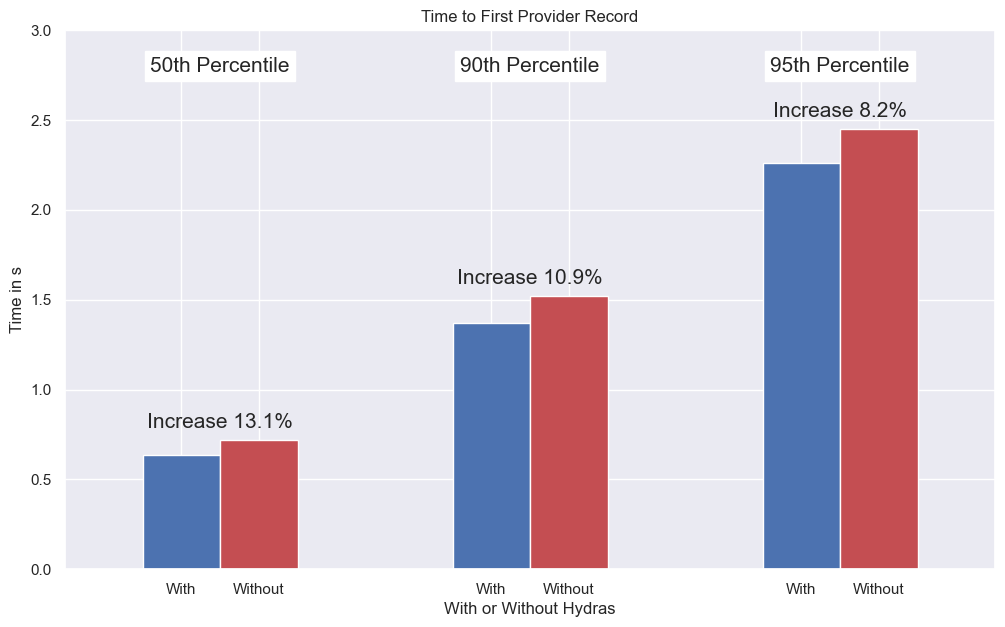

In [87]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []
for i, percentile in enumerate([50, 90, 95]):
    dat = np.array(list(
        map(lambda ret: (ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds(),
            retrievals_by_hydras["with"])))
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width / 2, with_percentile, width, label="With Hydras", color="b")

    dat = np.array(list(
        map(lambda ret: (ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds(),
            retrievals_by_hydras["without"])))
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i + width / 2, without_percentile, width, label="Without Hydras", color="r")
    print(percentile, without_percentile)
    ax.text(i, without_percentile + 0.1, f"Increase {without_percentile / with_percentile - 1:.1%}", ha="center",
            va="center", size=15)

    ax.text(i, 2.8, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width / 2, i + width / 2]
    labels += ["With", "Without"]

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 3)

Text(0.5, 0, 'With or Without Hydras')

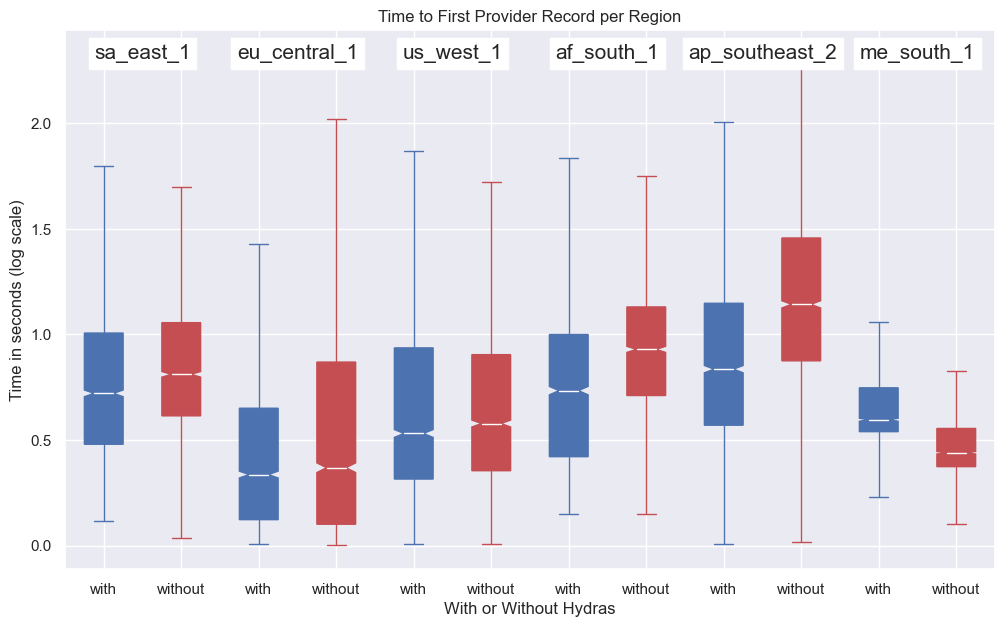

In [11]:
fig, ax = plt.subplots(figsize=[12, 7])

regions = log_no_to_region.values()

dats = []
labels = []
positions = []
for j, region in enumerate(reversed(regions)):
    for i, hydra in enumerate(["with", "without"]):
        dats += [np.array(dht_ret_find_first_provider_per_region_by_hydras[hydra][region])]
        labels += [f"{hydra}"]
    ax.text(2*j+1+1/2, 2.33, region, ha="center", va="center", size=15,bbox=dict(fc="w", lw=1))
bplot = ax.boxplot(dats, notch=True, labels=labels,patch_artist=True, showfliers=False)


colors = ['b', 'r']
for i, patch in enumerate(bplot["boxes"]):
    patch.set_color(colors[i%2])
    patch.set_facecolor(colors[i%2])

for i, patch in enumerate(bplot["medians"]):
    patch.set_color("w")

for i, patch in enumerate(bplot["fliers"]):
    patch.set_color("gray")

for item in ["whiskers", "caps"]:
    for i, patch in enumerate(bplot[item]):
        j = i //2
        patch.set_color(colors[j%2])

# ax.set_yscale("log")
# ax.set_ylim(ymax=20)
ax.set_ylabel("Time in seconds (log scale)")
ax.set_title(f"Time to First Provider Record per Region")
ax.set_xlabel("With or Without Hydras")